In [1]:
# Load library
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.ensemble.partial_dependence import plot_partial_dependence

In [2]:
# File directory (Please change it to where dataset is located)
dir = 'F:/ILS Data/ANALYTICS/Analytics Team Items/HoMan Chan/Others/DG/'

# Import data
df = pd.read_csv(dir + 'ds_assessment_dataset_2024.csv', sep = ';')

# Part A. Data Exploration

In [3]:
# A quick view of data dimensions, data type and missing values 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 26 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Acc                               50000 non-null  int64  
 1   ApplianceCode                     50000 non-null  int64  
 2   ClaimAmount5YearTotal             50000 non-null  float64
 3   ClaimPast5YearCount               50000 non-null  int64  
 4   ClaimsToPlansRatio                50000 non-null  float64
 5   ClientAccountDesc                 50000 non-null  int64  
 6   CurrentDate                       50000 non-null  object 
 7   DNISCode                          47384 non-null  object 
 8   Fee                               50000 non-null  float64
 9   ManufacturerBrandCode             50000 non-null  int64  
 10  ManufacturerGuaranteePartsMonths  50000 non-null  int64  
 11  OfferPostcodeSector               50000 non-null  object 
 12  Plan

In [4]:
# Identify categorical features
df.select_dtypes(['object']).columns

Index(['CurrentDate', 'DNISCode', 'OfferPostcodeSector', 'PrevRTPPriceType',
       'RTPPriceType', 'offerreferencenumber', 'pricingversiondescription'],
      dtype='object')

More EDA can be found in the Excel workbook inside the repository. 

# Part B. Price Elasticity

In [5]:
# Subset data by pricing strategy
df_asis = df[df['pricingversiondescription'] == 'QUO - ASIS FEE'].reset_index(drop = True) 
df_model = df[df['pricingversiondescription'] == 'QUO - MODEL Q'].reset_index(drop = True) 
df_test = df[df['pricingversiondescription'] == 'QUO - PRICE TEST'].reset_index(drop = True) 

# Average premium
p_asis = df_asis['Premium'].mean()
p_model = df_model['Premium'].mean()
p_test = df_test['Premium'].mean()

# Price variation
p_model_var = p_model / p_asis - 1
p_test_var = p_test / p_asis - 1

# Conversion rate
c_asis = df_asis['Acc'].sum() / df_asis.shape[0]
c_model = df_model['Acc'].sum() / df_model.shape[0]
c_test = df_test['Acc'].sum() / df_test.shape[0]

# Conversion variation
c_model_var = c_model / c_asis - 1
c_test_var = c_test / c_asis - 1

# Print results
print('Price elasticity of model vs. asis : %.3f' % (c_model_var / p_model_var))
print('Price elasticity of price test vs. asis : %.3f' % (c_test_var / p_test_var))

Price elasticity of model vs. asis : 36.922
Price elasticity of price test vs. asis : 36.463


In [6]:
# Turn 'CurrentDate' into datetime 
df_test['CurrentDate'] = pd.to_datetime(df_test['CurrentDate'])

# Subset data by year and month for price test group
df_test_0224 = df_test[(df_test['CurrentDate'].dt.year == 2024) & (df_test['CurrentDate'].dt.month == 2)].reset_index(drop = True)
df_test_0124 = df_test[(df_test['CurrentDate'].dt.year == 2024) & (df_test['CurrentDate'].dt.month == 1)].reset_index(drop = True)

# Average premium
p_test_0224 = df_test_0224['Premium'].mean()
p_test_0124 = df_test_0124['Premium'].mean()

# Price variation
p_test_grp_var = p_test_0224 / p_test_0124 - 1

# Conversion rate
c_test_0224 = df_test_0224['Acc'].sum() / df_test_0224.shape[0]
c_test_0124 = df_test_0124['Acc'].sum() / df_test_0124.shape[0]

# Conversion variation
c_test_grp_var = c_test_0224 / c_test_0124 - 1

# Print result
print('Price elasticity of price test group : %.3f' % (c_test_grp_var / p_test_grp_var))

Price elasticity of price test group : -5.277


People are usually discouraged by any price increase, so it is expected that conversion rate drops as premium increases. This explains why price elasticity within a group is negative. 

In contrast, price elasticity of one group verus other reflects the impact on demand when switching from a pricing strategy to another. The positive values tell us positive impact on demand when switching from asis to model / price test.

# Part C. Model Development & Evaluations

## Data Pre-processing

In [7]:
# A quick view of the modeling dataset
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8617 entries, 0 to 8616
Data columns (total 26 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   Acc                               8617 non-null   int64         
 1   ApplianceCode                     8617 non-null   int64         
 2   ClaimAmount5YearTotal             8617 non-null   float64       
 3   ClaimPast5YearCount               8617 non-null   int64         
 4   ClaimsToPlansRatio                8617 non-null   float64       
 5   ClientAccountDesc                 8617 non-null   int64         
 6   CurrentDate                       8617 non-null   datetime64[ns]
 7   DNISCode                          8151 non-null   object        
 8   Fee                               8617 non-null   float64       
 9   ManufacturerBrandCode             8617 non-null   int64         
 10  ManufacturerGuaranteePartsMonths  8617 non-null 

I'm going to get rid of some features because:
- There are too many missing values. (PreRTPPriceType and predictedconversionrate)
- Irrelevant to prediction. (ClientAccountDesc, CurrentDate, RTPPriceType, offerreferencenumber, pricingversiondescription)

For rest of the categorical features, I'll check if they are nominal or ordinal then apply different encoding methods accordingly.

### - Appliance Code

In [8]:
df_test['ApplianceCode'].unique()

array([38, 67,  3, 16,  6, 22, 28,  5, 26, 60, 49,  7,  2,  9, 35, 15, 23,
       17, 59, 53, 41, 61, 31, 48, 66, 34, 46, 45, 11,  4, 33, 25, 14, 47,
       44, 57, 39, 54, 69, 18, 24,  8,  1, 37, 12, 56, 40, 42, 58, 21, 52],
      dtype=int64)

Too many class levels. I'll drop it for now. It might be useful in feature creation (part d) though.

### - DNIS Code

In [9]:
df_test['DNISCode'].unique()

array(['CQ9R1', 'RR3A1', 'SQ9R1', 'RR1K1', 'OQ4Q1', 'QQ9R1', 'OQ9R1',
       'RR0Y1', 'RR4Q1', 'RR8A1', nan, 'CQ0C1', 'CQ4Q1', 'RR2M1', 'RR471',
       'RR691', 'RR041', 'RR4A2', 'RR1P1', 'SQ2M1', 'MQ9R1', 'TQ9R1',
       'RR6D1', 'RR5E1', 'SQ152', 'SQ4A1', 'RR9J1', 'SQ011', 'CQ0Y1',
       'OSA21', 'RE9A1', 'SQ0C1', 'RR9R1', 'SQ4Q1', 'QQ1P1', 'RR191',
       'RR5B1', 'RR7C1', 'SQ0Y1', 'SQ0U1', 'SB9A1', 'QQ4Q1', 'RR0Z1',
       'RR661', 'SQ9J1', 'SQ9X1', 'RR0U1', 'CQ2Z1', 'SQ041', 'RR6W1',
       'RR0T1', 'RR9Q1', 'CQ2M1', 'RR9K1', 'CQ9J1', 'RR1C1', 'SQ661',
       'SBFI1', 'RR7V1', 'RR311', 'SK4F1', 'SSA21', 'SQ2Z1', 'RR8M1',
       'TQ0C1', 'REFI1', 'CQ9X1', 'RR8D1', 'RR081', 'OQ2Z1', 'RK4F1',
       'RR161', 'SQ221', 'RR881', 'RR9X1', 'SQD81', 'SB9M1', 'OQ9J1'],
      dtype=object)

Drop it for the same reason as 'ApplianceCode'. 

### - Manufacturer Brand Code

In [10]:
df_test['ManufacturerBrandCode'].unique()

array([233, 135, 128, 261,  46, 131,  32, 273, 282, 195, 228, 148, 327,
       161, 212, 304,  39,  30, 207, 272, 235,  48,  80, 127, 175, 215,
        87, 181,  76, 159, 171, 143, 137, 251, 221, 187, 108,  59, 208,
       218,   4, 271, 323, 216,  69, 314, 168, 196,  37, 295, 257,  27,
       286,  13, 289, 211, 223,  68, 117, 302, 104,  74, 279,  83,   0,
       305, 200, 121, 201, 210, 202, 188,  55,  29, 123, 100,  85,  86,
        51,  61, 180,  40, 213,  35,  64, 315, 142, 325,  18, 179, 177,
        43, 209,  50, 293, 154, 206,  78, 283, 106, 309, 170, 236, 103,
       292, 237,  97,  38, 243, 249,  15, 141, 253, 146, 182, 265, 276,
       184, 157,  49, 264, 319, 118, 263, 124, 306,  16, 230,  22,  92,
        34,   7, 112,  57, 160, 328, 299, 326, 300, 288,  12, 115,  54,
       320,  96, 301, 101, 258, 281,  66,  21,  79, 255, 126, 266, 239,
       172, 183, 136, 242, 219, 308, 129,  70, 324,  44, 205,  17, 294,
        81, 125, 214, 162, 153, 156, 321, 312,  71, 105,   6, 24

Drop it for the same reason as 'ApplianceCode'.

### - Manufacturer Guarantee Parts Months

In [11]:
df_test['ManufacturerGuaranteePartsMonths'].unique()

# Ordinal mapping 
df_test['ManufacturerGuaranteePartsMonths'] = df_test['ManufacturerGuaranteePartsMonths'].map({12:1, 24:2, 36:3, 60:4, 120:5})

This is ordinal, so I encoded it 1 - 5 manually.

### - Scheme Type Name

In [12]:
df_test['SchemeTypeName'].unique()

df_new = df_test.copy()

df_new = df_new.drop(['ApplianceCode', 'ClientAccountDesc', 'CurrentDate', 'PrevRTPPriceType', 'RTPPriceType', 
                      'offerreferencenumber', 'predictedconversionrate', 'pricingversiondescription', 'DNISCode', 
                      'OfferPostcodeSector', 'ManufacturerBrandCode'], axis = 1)

This is nominal, so I applied one-hot encoding.

## Feature Engineering

In [13]:
# Convert categorical data into dummy variables
df_enc = pd.get_dummies(df_new, columns = ['SchemeTypeName'])

df_enc.shape

(8617, 21)

In [14]:
# Target variable
model_resp = df_enc['Acc']

# Predictor variables
model_data = df_enc.drop(['Acc'], axis = 1)

In [15]:
# Normalize data from original scale to a range of 0 - 1
scaler = MinMaxScaler()

data_rescaled = scaler.fit_transform(model_data)

model_data = pd.DataFrame(data = data_rescaled, columns = model_data.columns)

model_data.describe()

E:\Anaconda3\envs\HMC_env\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


,ClaimAmount5YearTotal,ClaimPast5YearCount,ClaimsToPlansRatio,Fee,ManufacturerGuaranteePartsMonths,PlanLiveCount,PlansAcceptedPast5YearCount,PlansCancelledPast5YearCount,Premium,PurchasePrice,age_appliance_days,price_diff,relFee,SchemeTypeName_0,SchemeTypeName_1,SchemeTypeName_2,SchemeTypeName_3,SchemeTypeName_4,SchemeTypeName_5,SchemeTypeName_6
count,8617.000000,8617.000000,8617.000000,8617.000000,8617.000000,8617.000000,8617.000000,8617.000000,8617.000000,8617.000000,8617.000000,8617.000000,8617.000000,8617.000000,8617.000000,8617.000000,8617.000000,8617.000000,8617.000000,8617.000000
mean,0.023181,0.033981,0.062217,0.526184,0.243385,0.060568,0.022347,0.021033,0.540403,0.351454,0.342876,0.500817,0.005145,0.572009,0.026111,0.038761,0.037948,0.015203,0.043867,0.266102
std,0.049852,0.063119,0.095875,0.237652,0.369092,0.081430,0.039358,0.042825,0.251114,0.205645,0.257546,0.271284,0.035731,0.494816,0.159475,0.193035,0.191082,0.122365,0.204811,0.441944
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.350926,0.000000,0.000000,0.000000,0.000000,0.353680,0.249374,0.111688,0.274266,0.002022,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.004009,0.008772,0.025000,0.510185,0.000000,0.027778,0.008511,0.005000,0.523339,0.289391,0.334147,0.500000,0.003046,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.026099,0.043860,0.100000,0.694444,0.250000,0.083333,0.029787,0.025000,0.713645,0.416180,0.557217,0.730369,0.004024,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Building Lasso Regression model

In [16]:
# train test split
train_data, test_data, train_resp, test_resp = train_test_split(model_data, model_resp, test_size=0.30, random_state=42)

print('Train response mean: %.3f' % train_resp.mean()) 
print('Test response mean: %.3f' % test_resp.mean())  

Train response mean: 0.341
Test response mean: 0.349


In [17]:
# Lasso regression
lasso = LogisticRegression(penalty = 'l1', solver = 'liblinear', max_iter = 1000, random_state = 42)
lasso.fit(train_data, train_resp)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=42, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [18]:
# Generate probability scores based on train / test
train_prob = lasso.predict_proba(train_data)[:, 1]
test_prob = lasso.predict_proba(test_data)[:, 1]

# Compare response rates between train and test to see any overfitting
print('Train probability score mean: %.3f' % train_prob.mean()) 
print('Test probability score mean: %.3f' % test_prob.mean())    

# Get AUC for train set and test set
lasso_train_auc = roc_auc_score(train_resp, train_prob)
lasso_test_auc = roc_auc_score(test_resp, test_prob)
print('AUC (train): %.3f' % lasso_train_auc)       
print('AUC (test): %.3f' % lasso_test_auc)  

# Calculate false positive rate and false negative rate 
test_pred = lasso.predict(test_data)
tn, fp, fn, tp = confusion_matrix(test_resp, test_pred).ravel()
lasso_fnr = fn / (tp + fn)
print('False Negative Rate : %.3f' % lasso_fnr)

Train probability score mean: 0.341
Test probability score mean: 0.345
AUC (train): 0.783
AUC (test): 0.758
False Negative Rate : 0.558


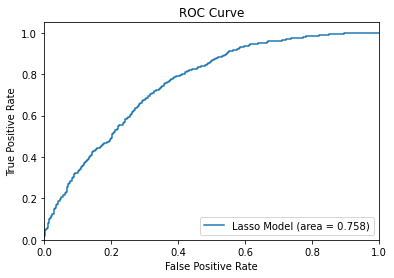

In [19]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(test_resp, test_prob)

plt.figure()
plt.plot(fpr, tpr, label='Lasso Model (area = %0.3f)' % roc_auc_score(test_resp, test_prob))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

## Build AdaBoost model

In [20]:
adb = AdaBoostClassifier(n_estimators = 100, random_state = 42)
adb.fit(train_data, train_resp)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=100, random_state=42)

In [21]:
# Generate probability scores based on train / test
train_prob = adb.predict_proba(X = train_data)[:, 1]
test_prob = adb.predict_proba(X = test_data)[:, 1]

# Compare response rates between train and test to see any overfitting
print('Train probability score mean: %.3f' % train_prob.mean()) 
print('Test probability score mean: %.3f' % test_prob.mean())  

# Get AUC for train set and test set
adb_train_auc = roc_auc_score(train_resp, train_prob)
adb_test_auc = roc_auc_score(test_resp, test_prob)
print('AUC (train): %.3f' % adb_train_auc)
print('AUC (test): %.3f' % adb_test_auc)

# Calculate false positive rate and false negative rate 
test_pred = adb.predict(test_data)
tn, fp, fn, tp = confusion_matrix(test_resp, test_pred).ravel()
adb_fnr = fn / (tp + fn)
print('False Negative Rate : %.3f' % adb_fnr) 

Train probability score mean: 0.498
Test probability score mean: 0.498
AUC (train): 0.825
AUC (test): 0.771
False Negative Rate : 0.531


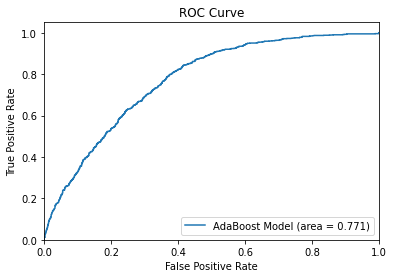

In [22]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(test_resp, test_prob)

plt.figure()
plt.plot(fpr, tpr, label='AdaBoost Model (area = %0.3f)' % roc_auc_score(test_resp, test_prob))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

## Building GBM model

In [23]:
gbm = GradientBoostingClassifier(max_features='sqrt', n_iter_no_change=10, tol=0.001, random_state = 42)
gbm.fit(train_data, train_resp)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=10, presort='auto', random_state=42,
              subsample=1.0, tol=0.001, validation_fraction=0.1, verbose=0,
              warm_start=False)

In [24]:
# Generate probability scores based on train / test
train_prob = gbm.predict_proba(X = train_data)[:, 1]
test_prob = gbm.predict_proba(X = test_data)[:, 1]

# Compare response rates between train and test to see any overfitting
print('Train probability score mean: %.3f' % train_prob.mean()) 
print('Test probability score mean: %.3f' % test_prob.mean())  

# Get AUC for train set and test set
gbm_train_auc = roc_auc_score(train_resp, train_prob)
gbm_test_auc = roc_auc_score(test_resp, test_prob)
print('AUC (train): %.3f' % gbm_train_auc)
print('AUC (test): %.3f' % gbm_test_auc)

# Calculate false positive rate and false negative rate 
test_pred = gbm.predict(test_data)
tn, fp, fn, tp = confusion_matrix(test_resp, test_pred).ravel()
gbm_fnr = fn / (tp + fn)
print('False Negative Rate : %.3f' % gbm_fnr) 

Train probability score mean: 0.342
Test probability score mean: 0.343
AUC (train): 0.846
AUC (test): 0.784
False Negative Rate : 0.534


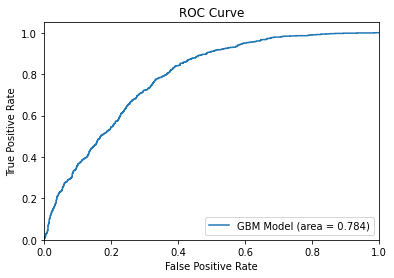

In [25]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(test_resp, test_prob)

plt.figure()
plt.plot(fpr, tpr, label='GBM Model (area = %0.3f)' % roc_auc_score(test_resp, test_prob))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

For hyperparameter tuning of GBM, I would focus on parameters "min_impurity_decrease", "learning_rate", "n_estimators", "max_depth", "min_samples_split", "min_samples_leaf", "subsample", "max_features", and tune them one by one. The steps I usually take are as follows.
1. Create a list of parameter setting dict.
2. Assign the list to "param_grid" inside GridSearchCV and run 5-fold cross validation.
3. Once the run finished, use attributes "best_params_" and "best_score_" to compare the score (e.g. AUC) and parameter setting of the best estimator with the previous run.
4. Assign the best parameter setting to the corresponding parameter.
5. Repeat step 1 - 4 until all parameters are tuned or no AUC uplift can be seen.

In [26]:
# Combine results of the 3 models for easy comparison
data = [['Lasso', lasso_test_auc, lasso_fnr], ['AdaBoost', adb_test_auc, adb_fnr],
       ['GBM', gbm_test_auc, gbm_fnr]]
result = pd.DataFrame(data, columns = ['Model', 'AUC', 'False Negative Rate'])
print(result)

      Model       AUC  False Negative Rate
0     Lasso  0.758047             0.557650
1  AdaBoost  0.771468             0.531042
2       GBM  0.784349             0.534368


AUC is the standard metric in every model evaluation. Additionally, business needs should be taken account into measuring the performance of machine learning models. In my experience, no quote return or irrational quote return could be resulted when an underwriter believed customers were unlikely to buy. If this is the case in D&G, false negative cases should be concerned as they lead to lost opportunity. 

GBM model achieved the highest AUC among the 3 models. Though it came second behind AdaBoost model in false positive rate, the difference is not significant. Additionally, GradientBoostingClassifier offers many options of hyperparameters for tuning, which leaves more rooms for model performance improvement. Therefore, I would select GBM model to be 'go-to' model in predicting demand. 

# Part D. Feature Creation

(Please refer below to the Excel workbook in the repository)

For the categorical features that I dropped earlier, I calculated volume proportions and conversion rate of different class levels for each of them. If any class level had volume proportions greater than 10% and conversion rate greater than 34.3%, I would create a flag variable for that class level. 

In [27]:
model_data_fc = model_data.copy()

model_data_fc['SQ9R1_flag'] = df_test['DNISCode'] == 'SQ9R1'
model_data_fc['CQ9R1_flag'] = df_test['DNISCode'] == 'CQ9R1'
model_data_fc['QQ9R1_flag'] = df_test['DNISCode'] == 'QQ9R1'
model_data_fc['Appliance38_flag'] = df_test['ApplianceCode'] == '38'
model_data_fc['Brand261_flag'] = df_test['ManufacturerBrandCode'] == '261'

E:\Anaconda3\envs\HMC_env\lib\site-packages\pandas\core\ops\array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


In [28]:
# train test split
train_data, test_data, train_resp, test_resp = train_test_split(model_data_fc, model_resp, test_size=0.30, random_state=42)

print('Train response mean: %.3f' % train_resp.mean()) 
print('Test response mean: %.3f' % test_resp.mean())  

Train response mean: 0.341
Test response mean: 0.349


In [29]:
gbm.fit(train_data, train_resp)

# Generate probability scores based on train / test
train_prob = gbm.predict_proba(X = train_data)[:, 1]
test_prob = gbm.predict_proba(X = test_data)[:, 1]

# Compare response rates between train and test to see any overfitting
print('Train probability score mean: %.3f' % train_prob.mean()) 
print('Test probability score mean: %.3f' % test_prob.mean())  

# Get AUC for train set and test set
gbm_fc_train_auc = roc_auc_score(train_resp, train_prob)
gbm_fc_test_auc = roc_auc_score(test_resp, test_prob)
print('AUC (train): %.3f' % gbm_fc_train_auc)
print('AUC (test): %.3f' % gbm_fc_test_auc)

# Calculate false positive rate and false negative rate 
test_pred = gbm.predict(test_data)
tn, fp, fn, tp = confusion_matrix(test_resp, test_pred).ravel()
gbm_fc_fpr = fp / (fp + tn)
gbm_fc_fnr = fn / (tp + fn)
print('False Positive Rate : %.3f' % gbm_fc_fpr)
print('False Negative Rate : %.3f' % gbm_fc_fnr) 

Train probability score mean: 0.342
Test probability score mean: 0.344
AUC (train): 0.854
AUC (test): 0.794
False Positive Rate : 0.149
False Negative Rate : 0.502


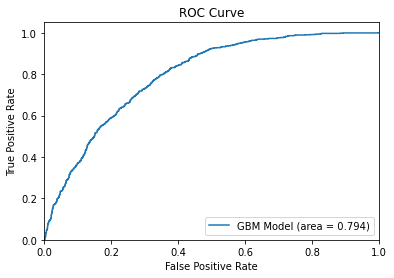

In [30]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(test_resp, test_prob)

plt.figure()
plt.plot(fpr, tpr, label='GBM Model (area = %0.3f)' % roc_auc_score(test_resp, test_prob))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

Given by the addition of the 5 new features, the demand model improved with a 1.3% uplift in AUC (0.784 vs. 0.794).

# Part E. Top 5 Most Important Features  

                            Variable       Imp
10                age_appliance_days  0.184465
11                        price_diff  0.156615
3                                Fee  0.107148
19                  SchemeTypeName_6  0.093948
5                      PlanLiveCount  0.067967
8                            Premium  0.054767
6        PlansAcceptedPast5YearCount  0.052465
16                  SchemeTypeName_3  0.046356
4   ManufacturerGuaranteePartsMonths  0.035693
22                        QQ9R1_flag  0.035208


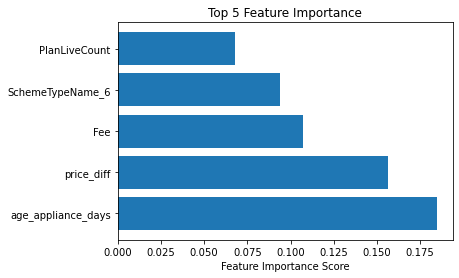

In [31]:
# Get feature importance values, sort in descending order, and show top 10 only
FeatureImp = pd.DataFrame(list(train_data.columns)).copy()
FeatureImp.insert(len(FeatureImp.columns), 'Imp', gbm.feature_importances_.transpose())
FeatureImp = FeatureImp[FeatureImp.Imp != 0]
FeatureImp.rename(columns={0: 'Variable'}, inplace=True)
FeatureImp = FeatureImp.sort_values(by='Imp', ascending=False)
print(FeatureImp.head(10))

# Plot the top 5 highest Feature Importance
plt.clf()
plt.barh(FeatureImp['Variable'].head(5), FeatureImp['Imp'].head(5))
plt.title('Top 5 Feature Importance')
plt.xlabel('Feature Importance Score')
plt.show()

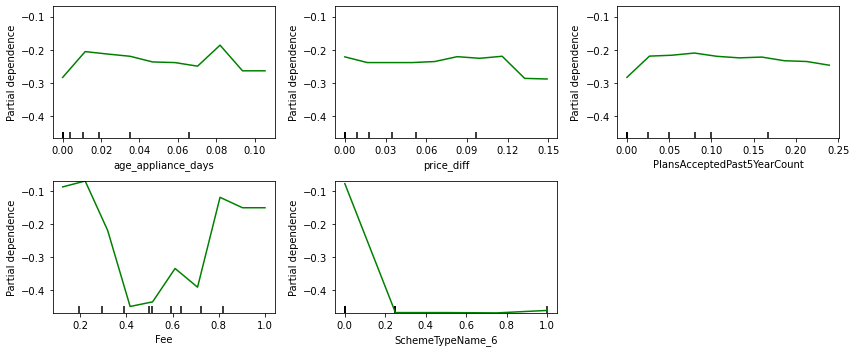

In [32]:
# Partial independence plot
fig, ax = plot_partial_dependence(gbm,       
                                   features = [0, 1, 2, 3, 4], 
                                   X = model_data_fc,            # raw predictors data.
                                   feature_names = ['age_appliance_days', 'price_diff', 'PlansAcceptedPast5YearCount',
                                                   'Fee', 'SchemeTypeName_6'], 
                                   grid_resolution = 10) # number of values to plot on x axis

fig.set_figwidth(12)
fig.set_figheight(5)
fig.tight_layout()

Based on the feature importance score, the model believed age_appliance_days was the most important feature in prediction. 

Partial dependence plot suggests a non-linear relationship between age_appliance_days and the predicted outcome (i.e. likelihood to accept) as the line exhibits bends. In general, customers tend to accept D&G's quotes after they bought their appliances not long ago. As the appliance age grew, customers no longer saw the necessity for product protection, so they became more reluctant to accept D&G's quotes. 

# Part F. What-if Analysis

In [33]:
# New data with premium increased by 10%
model_data_new = model_data_fc.copy()
model_data_new['Premium'] = model_data_fc['Premium'] * 1.1

# Score new data with GBM model
pred_conv_new = gbm.predict_proba(X = model_data_new)[:, 1]
print('Predicted conversion rate (after price increase): %.3f' % pred_conv_new.mean())

# Calculate conversion rate before price increase
conv = model_resp.sum() / model_resp.count()
print('Actual conversion rate (before price increase): %.3f' % conv)

# Use predicted conversion rate to work out price elasticity
print('Price elasticity : %.3f' % (((pred_conv_new.mean() / conv) - 1) / 0.1))

Predicted conversion rate (after price increase): 0.339
Actual conversion rate (before price increase): 0.343
Price elasticity : -0.114


The GBM model predicted the conversion rate would be 33.8% after 10% premium increase, which is 0.5% drop compared to the actual conversion rate before change. Price elasticity adjusted from -5.277 (obtained from part b) to -0.114.